# Compare COSIMA cookbook catalogue to basic intake ESM catalogue

In [1]:
%cd /g/data/xv83/users/ds0092/sandpit/

/g/data/xv83/users/ds0092/sandpit


In [2]:
import glob
 
import pathlib

import xarray as xr

from distributed import Client

In [3]:
client = Client()
client

/g/data/xv83/users/ds0092/software/miniconda3/envs/intake/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36999 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36999/status,
Dashboard: /proxy/36999/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41795,Workers: 7
Dashboard: /proxy/36999/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:43299,Total threads: 1
Dashboard: /proxy/40549/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:32965,


## Let's index one experiment containing 5.5TB of data spread across slightly over 2000 netcdf files

In [4]:
index_directory = "/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6"

## 1. Index and load some data from an experiment using the cosima cookbook approach

In [5]:
import cosima_cookbook as cc

### Build the cosima database with a multithreaded client similar to the approach used by `ecgtools` below

In [7]:
%%time

db = "cosima_cookbook_test.db"
session = cc.database.create_session(db)

cc.database.build_index([index_directory], session, client=client)

Indexing experiment: 025deg_jra55_iaf_omip2_cycle6


  0%|          | 0/14 [00:00<?, ?it/s]ERROR:root:Error indexing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/restart324/ice/kmt.nc: 'nEdits'
ERROR:root:Error indexing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/restart334/ice/kmt.nc: 'nEdits'
 14%|█▍        | 2/14 [00:00<00:00, 12.05it/s]ERROR:root:Error indexing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/restart319/ice/kmt.nc: 'nEdits'
ERROR:root:Error indexing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/restart359/ice/kmt.nc: 'nEdits'
 29%|██▊       | 4/14 [00:00<00:00, 13.79it/s]ERROR:root:Error indexing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/restart304/ice/kmt.nc: 'nEdits'
ERROR:root:Error indexing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/restart354/ice/kmt.nc: 'nEdits'
ERROR:root:Error indexing /g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/restart349/ice/kmt.nc: 'nEdits'
 5

CPU times: user 1.33 s, sys: 395 ms, total: 1.73 s
Wall time: 3.49 s


14

In [8]:
%%time

experiment = '025deg_jra55_iaf_omip2_cycle6'

sst = cc.querying.getvar(experiment, "sst", session, ncfile="ocean_month.nc")
area = cc.querying.getvar(experiment, "area_t", session, ncfile="ocean_grid.nc", n=1)

CPU times: user 1.26 s, sys: 510 ms, total: 1.77 s
Wall time: 4.91 s


CPU times: user 1min 2s, sys: 1.65 s, total: 1min 4s
Wall time: 1min 13s


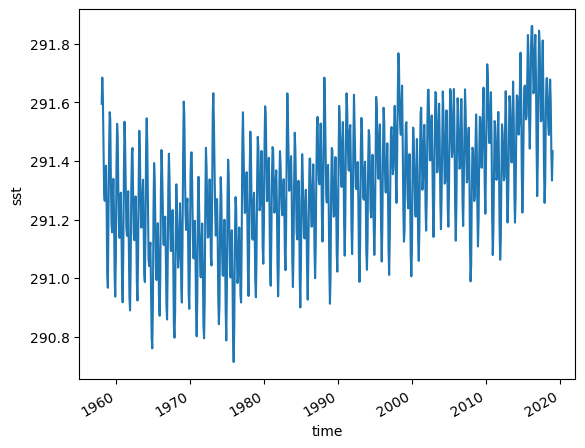

In [9]:
%%time

global_mean = sst.weighted(area.fillna(0)).mean(["xt_ocean", "yt_ocean"])
_ = global_mean.plot()

## 2. Index and load some data from an experiment using ecgtools and intake-esm

In [49]:
import traceback

import cftime

from ecgtools import Builder
from ecgtools.builder import INVALID_ASSET, TRACEBACK
from ecgtools.parsers.utilities import extract_attr_with_regex

### Build and save the catalogue

In [79]:
from cosima_cookbook import netcdf_utils

def parse_cc(file):
    """Quick hacked parser for COSIMA datasets"""
    def _get_timeinfo(ds):
        """
        Stolen and slightly adapted from cosima cookbook 
        https://github.com/COSIMA/cosima-cookbook/blob/master/cosima_cookbook/database.py#L565
        """
        time_dim = "time" # TODO: this probably shouldn't be hardcoded
        if time_dim is None:
            return None

        time_var = ds[time_dim]
        has_bounds = hasattr(time_var, "bounds") and time_var.bounds in ds.variables
        
        def _todate(t):
            return cftime.num2date(t, time_var.units, calendar=time_var.calendar)
    
        if has_bounds:
            bounds_var = ds.variables[time_var.bounds]
            start_time = _todate(bounds_var[0, 0])
            end_time = _todate(bounds_var[-1, 1])
        else:
            start_time = _todate(time_var[0])
            end_time = _todate(time_var[-1])
        
        if len(time_var) > 1 or has_bounds:
            if has_bounds:
                next_time = _todate(bounds_var[0, 1])
            else:
                next_time = _todate(time_var[1])

            dt = next_time - start_time
            if dt.days >= 365:
                years = round(dt.days / 365)
                frequency = f"{years} yearly"
            elif dt.days >= 28:
                months = round(dt.days / 30)
                frequency = f"{months} monthly"
            elif dt.days >= 1:
                frequency = f"{dt.days} daily"
            else:
                frequency = f"{dt.seconds // 3600} hourly"
        else:
            # single time value in this file and no averaging
            frequency = "static"
            
        return start_time.strftime("%Y-%m-%d"), end_time.strftime("%Y-%m-%d"), frequency
        
    path = pathlib.Path(file)
    
    try:
        path_parts = path.parts
        filename = path.stem
        # TODO: this can be done better
        # First 5 parts are /,g,data,ik11,outputs,access-om2
        experiment = path_parts[6]
        output = path_parts[7]
        realm = path_parts[8]

        with xr.open_dataset(file, chunks={}, decode_times=False) as ds:
            variable_list = [var for var in ds if 'long_name' in ds[var].attrs]

        info = {
                "experiment": experiment,
                "output": output,
                "realm": realm,
                "variables": variable_list,
                'filename': filename,
                "path": str(file),
            }
        info["start_time"], info["end_time"], info["frequency"] = _get_timeinfo(ds)

        return info

    except Exception:
        return {INVALID_ASSET: file, TRACEBACK: traceback.format_exc()}

In [80]:
%%time

cc_builder = Builder(
    index_directory,
    depth=0,
    exclude_patterns=["*/restart*/*"], # Exclude restart directories
    njobs=-1,
)

cc_builder = cc_builder.build(parsing_func=parse_cc)

cc_builder.save(
    "cosima_cookbook_test.csv",
    path_column_name='path',
    variable_column_name='variables',
    data_format="netcdf",
    # Which attributes to groupby when reading in variables using intake-esm
    groupby_attrs=["experiment", "filename"],
    aggregations=[
        {
            "type": "join_existing",
            "attribute_name": "start_time",
            "options": {"dim": "time", "coords": "minimal", "compat": "override"},
        }
    ],
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  65 out of  78 | elapsed:    2.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 1212 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 1878 out of 1891 | elapsed:   28.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1891 out of 1891 | elapsed:   28.4s finished
  ).clean_dataframe()




Saved catalog location: cosima_cookbook_test.json and cosima_cookbook_test.csv
CPU times: user 1.99 s, sys: 424 ms, total: 2.41 s
Wall time: 31.1 s


In [81]:
cc_builder.df

,experiment,output,realm,variables,filename,path,start_time,end_time,frequency
0,025deg_jra55_iaf_omip2_cycle6,output305,ice,"[time_bounds, NCAT, tmask, blkmask, tarea, uar...",iceh.1958-01-daily,/g/data/ik11/outputs/access-om2-025/025deg_jra...,1958-01-01,1958-02-01,1 daily
1,025deg_jra55_iaf_omip2_cycle6,output305,ice,"[time_bounds, tmask, blkmask, tarea, uarea, dx...",iceh.1958-01,/g/data/ik11/outputs/access-om2-025/025deg_jra...,1958-01-01,1958-02-01,1 monthly
2,025deg_jra55_iaf_omip2_cycle6,output305,ice,"[time_bounds, NCAT, tmask, blkmask, tarea, uar...",iceh.1958-02-daily,/g/data/ik11/outputs/access-om2-025/025deg_jra...,1958-02-01,1958-03-01,1 daily
3,025deg_jra55_iaf_omip2_cycle6,output305,ice,"[time_bounds, tmask, blkmask, tarea, uarea, dx...",iceh.1958-02,/g/data/ik11/outputs/access-om2-025/025deg_jra...,1958-02-01,1958-03-01,1 monthly
4,025deg_jra55_iaf_omip2_cycle6,output305,ice,"[time_bounds, NCAT, tmask, blkmask, tarea, uar...",iceh.1958-03-daily,/g/data/ik11/outputs/access-om2-025/025deg_jra...,1958-03-01,1958-04-01,1 daily
...,...,...,...,...,...,...,...,...,...
1886,025deg_jra55_iaf_omip2_cycle6,output365,ocean,"[sst, sst_sq, sss, sss_sq, hblt_max, mld, mld_...",ocean_daily,/g/data/ik11/outputs/access-om2-025/025deg_jra...,2017-12-30,2018-12-30,1 daily
1887,025deg_jra55_iaf_omip2_cycle6,output365,ocean,"[ht, hu, dxt, dyt, dxu, dyu, area_t, area_u, k...",ocean_grid,/g/data/ik11/outputs/access-om2-025/025deg_jra...,2018-12-30,2018-12-30,static
1888,025deg_jra55_iaf_omip2_cycle6,output365,ocean,"[pbot_t, patm_t, rho_dzt, dht, sea_level, sea_...",ocean_month,/g/data/ik11/outputs/access-om2-025/025deg_jra...,2017-12-30,2018-12-30,1 monthly
1889,025deg_jra55_iaf_omip2_cycle6,output365,ocean,"[total_mass_seawater, total_volume_seawater, e...",ocean_scalar,/g/data/ik11/outputs/access-om2-025/025deg_jra...,2017-12-30,2018-12-30,1 monthly


In [63]:
# Some files failed to be indexed because they don't have a calendar attribute

cc_builder.invalid_assets.INVALID_ASSET.values

array([PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output305/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output306/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output307/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output308/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output309/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output310/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output311/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output312/ocean/o2i.nc'),
       PosixPath('/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6/output313/ocean/o2i.nc'),
       Pos

### Open some data

In [64]:
import ast

import intake

In [93]:
catalog = intake.open_esm_datastore(
    "cosima_cookbook_test.json",
    read_csv_kwargs={"converters": {"variables": ast.literal_eval}},
    sep="/",
)

In [98]:
%%time

subset = catalog.search(
    experiment="025deg_jra55_iaf_omip2_cycle6", 
    variables="sst")

dsets = subset.to_dataset_dict()
dsets 


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.filename'


CPU times: user 23.2 s, sys: 9.52 s, total: 32.7 s
Wall time: 20.5 s


{'025deg_jra55_iaf_omip2_cycle6.ocean_daily': <xarray.Dataset>
 Dimensions:   (time: 22280, yt_ocean: 1080, xt_ocean: 1440)
 Coordinates:
   * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
   * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
   * time      (time) datetime64[ns] 1957-12-30T12:00:00 ... 2018-12-29T12:00:00
 Data variables:
     sst       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(365, 1080, 1440), meta=np.ndarray>
 Attributes:
     filename:                        ocean_daily.nc
     title:                           ACCESS-OM2
     grid_type:                       mosaic
     grid_tile:                       1
     intake_esm_vars:                 ['sst']
     intake_esm_attrs:experiment:     025deg_jra55_iaf_omip2_cycle6
     intake_esm_attrs:realm:          ocean
     intake_esm_attrs:variables:      sst,sst_sq,sss,sss_sq,hblt_max,mld,mld_m...
     intake_esm_attrs:filename:       ocean_daily
     intake_e

In [108]:
sst = dsets["025deg_jra55_iaf_omip2_cycle6.ocean_month"]["sst"]

area = catalog.search(
    experiment="025deg_jra55_iaf_omip2_cycle6", 
    variables="area_t",
    start_time="2018-12-30").to_dataset_dict()[
    "025deg_jra55_iaf_omip2_cycle6.ocean_grid"]["area_t"]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.filename'


CPU times: user 32.8 s, sys: 7.43 s, total: 40.2 s
Wall time: 1min 44s


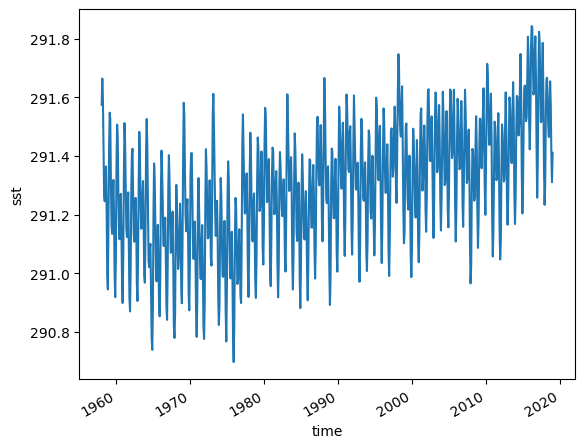

In [109]:
%%time

global_mean = sst.weighted(area.fillna(0)).mean(["xt_ocean", "yt_ocean"])
_ = global_mean.plot()

## Can the cosima cookbook approach handle multiple variables lazily?

In [113]:
cc.querying.getvar(experiment, ["sst", "mld", "eta_t"], session, ncfile="ocean_month.nc")

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 0 - probably unsupported type.
[SQL: SELECT ncfiles.id AS ncfiles_id, ncfiles.index_time AS ncfiles_index_time, ncfiles.ncfile AS ncfiles_ncfile, ncfiles.present AS ncfiles_present, ncfiles.experiment_id AS ncfiles_experiment_id, ncfiles.time_start AS ncfiles_time_start, ncfiles.time_end AS ncfiles_time_end, ncfiles.frequency AS ncfiles_frequency, ncvars.id AS ncvars_id, ncvars.ncfile_id AS ncvars_ncfile_id, ncvars.variable_id AS ncvars_variable_id, ncvars.dimensions AS ncvars_dimensions, ncvars.chunking AS ncvars_chunking 
FROM ncfiles JOIN ncvars ON ncfiles.id = ncvars.ncfile_id JOIN experiments ON experiments.id = ncfiles.experiment_id 
WHERE (EXISTS (SELECT 1 
FROM variables 
WHERE variables.id = ncvars.variable_id AND variables.name = ?)) AND experiments.experiment = ? AND ncfiles.present = 1 AND ncfiles.ncfile LIKE ? AND (EXISTS (SELECT 1 
FROM ncattributes 
WHERE ncvars.id = ncattributes.ncvar_id AND (EXISTS (SELECT 1 
FROM ncattribute_strings 
WHERE ncattribute_strings.id = ncattributes.name_id AND ncattribute_strings.value = ?)) AND (EXISTS (SELECT 1 
FROM ncattribute_strings 
WHERE ncattribute_strings.id = ncattributes.value_id AND ncattribute_strings.value = ?)))) ORDER BY ncfiles.time_start
 LIMIT ? OFFSET ?]
[parameters: (['sst', 'mld', 'eta_t'], '025deg_jra55_iaf_omip2_cycle6', '%ocean_month.nc', 'cell_methods', 'time: mean', 1, 0)]
(Background on this error at: https://sqlalche.me/e/14/rvf5)